In [65]:
%load_ext autoreload
%autoreload 2

import os
import requests
import numpy as np
import pandas as pd
import pyarrow.parquet as pq
import seaborn as sns
import matplotlib.pyplot as plt

from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from tqdm import tqdm
from sklearn.model_selection import GroupShuffleSplit

import sys
sys.path.append("..")
from pLMtrainer.dataloader import FrustrationDataModule
from pLMtrainer.models import FrustrationCNN
from pytorch_lightning import Trainer

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [80]:
metadata_file = "../../../biotrainer/frustration/data/pLM_senddata/sr_info_perpostition_all_proteins.parquet"
parquet_path = "../data/frustration/v3_frustration.parquet.gzip"

translate_dict = {"f1": 0, "f2": 1, "f3": 2, "f4": 3, "f5": 4, 
                  "f6": 5, "f7": 6, "f8": 7, "f9": 8, "f10": 9, 
                  "f11": 10, "f12": 11, "f13": 12, "f14": 13, "f15": 14, 
                  "f16": 15, "f17": 16, "f18": 17, "f19": 18, "f20": 19}
inv_translate_dict = {v: k for k, v in translate_dict.items()}

test_cath_ids = ["1.10.490.10", "3.40.710.10", "3.30.1710.10", "1.20.58.130", "3.40.50.300"]
test_cath_T = ["1.10.490", "3.40.710", "3.30.1710", "1.20.58"]#, "3.40.50"]

In [4]:
df_full = pq.read_table(metadata_file).to_pandas()
df_full.head()

,funfam_id,proteinID,Res,ChainRes,AA,FrstIndex,FrstClass
0,3.40.50.300-FF-000855,AF-A0A0R2D5W3-F1-model_v4_TED01,8,A,I,1.602,f7
1,3.40.50.300-FF-000855,AF-A0A0R2D5W3-F1-model_v4_TED01,9,A,V,1.395,f7
2,3.40.50.300-FF-000855,AF-A0A0R2D5W3-F1-model_v4_TED01,10,A,L,1.420,f7
3,3.40.50.300-FF-000855,AF-A0A0R2D5W3-F1-model_v4_TED01,11,A,S,-0.555,f12
4,3.40.50.300-FF-000855,AF-A0A0R2D5W3-F1-model_v4_TED01,12,A,G,-0.405,f11


In [5]:
df_full["cath_id"] = df_full["funfam_id"].astype(str).apply(lambda x: x.split("-")[0])
df_full

,funfam_id,proteinID,Res,ChainRes,AA,FrstIndex,FrstClass,cath_id
0,3.40.50.300-FF-000855,AF-A0A0R2D5W3-F1-model_v4_TED01,8,A,I,1.602,f7,3.40.50.300
1,3.40.50.300-FF-000855,AF-A0A0R2D5W3-F1-model_v4_TED01,9,A,V,1.395,f7,3.40.50.300
2,3.40.50.300-FF-000855,AF-A0A0R2D5W3-F1-model_v4_TED01,10,A,L,1.420,f7,3.40.50.300
3,3.40.50.300-FF-000855,AF-A0A0R2D5W3-F1-model_v4_TED01,11,A,S,-0.555,f12,3.40.50.300
4,3.40.50.300-FF-000855,AF-A0A0R2D5W3-F1-model_v4_TED01,12,A,G,-0.405,f11,3.40.50.300
...,...,...,...,...,...,...,...,...
187008291,1.10.510.10-FF-000137,4jbqA02,387,A,S,-0.333,f11,1.10.510.10
187008292,1.10.510.10-FF-000137,4jbqA02,388,A,S,0.494,f9,1.10.510.10
187008293,1.10.510.10-FF-000137,4jbqA02,389,A,K,-1.621,f14,1.10.510.10
187008294,1.10.510.10-FF-000137,4jbqA02,390,A,P,1.158,f8,1.10.510.10


In [81]:
df = pd.read_parquet(parquet_path)
df.head()

,proteinID,full_seq,res_seq,res_idx,frst_idx,frst_class,set,cath_T_id
0,AF-A0A009EQP3-F1-model_v4_TED02,MKESLRLRLDQLSDRHEELTALLADVEVISDNKRFRQLSREHNDLT...,"[Y, L, E, I, R, A, G, T, G, G, D, E, A, A, I, ...","[111, 112, 113, 114, 115, 116, 117, 118, 119, ...","[0.235, 1.632, -0.844, 1.365, 0.282, -0.384, 0...","[9, 6, 11, 6, 9, 10, 9, 9, 9, 11, 12, 13, 9, 8...",train,3.30.70
1,AF-A0A009F754-F1-model_v4_TED02,MANPAQLVRHKLLNTFFSRHSVWFACITIAVIFTIFHIGYEPRYIY...,"[R, I, L, I, G, N, E, Q, C, T, Q, P, Y, S, A, ...","[164, 165, 166, 167, 168, 169, 170, 171, 172, ...","[-1.068, 1.469, -0.317, 1.098, -0.663, -0.771,...","[12, 6, 10, 7, 11, 11, 7, 10, 3, 9, 13, 11, 9,...",train,3.20.20
2,AF-A0A009FNZ8-F1-model_v4_TED01,MFEKILIANRGEIACRVIRTAKKLGIRTVAVYSDADANAQHVKLAD...,"[I, L, I, A, N, R, G, E, I, A, C, R, V, I, R, ...","[4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,...","[1.272, 1.306, 1.196, 0.436, -1.334, -0.495, -...","[7, 7, 7, 9, 13, 11, 11, 11, 6, 9, 7, 10, 6, 7...",train,3.40.50
3,AF-A0A009G099-F1-model_v4_TED01,MNILIVHAHPEPLSFTTSLKTTAQQTLKKLGHQVEISDLYAMQFNP...,"[I, L, I, V, H, A, H, P, E, P, L, S, F, T, T, ...","[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1...","[1.237, 1.275, 1.28, 1.144, -0.344, 0.651, 0.3...","[7, 7, 7, 7, 10, 8, 9, 11, 12, 9, 7, 9, 7, 10,...",train,3.40.50
4,AF-A0A009G3U9-F1-model_v4_TED01,MPHDTEFELFRDSYRRFLKEQVAPYYEQWEHDGLIPRDLWLRLGEN...,"[E, F, E, L, F, R, D, S, Y, R, R, F, L, K, E, ...","[5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17...","[-1.274, 1.144, -0.261, -0.914, 1.071, 0.025, ...","[12, 7, 10, 12, 7, 9, 10, 11, 7, 7, 6, 12, 6, ...",train,1.10.540


In [169]:
df.loc[df['set'] == 'train', 'cath_T_id'].nunique(), \
df.loc[df['set'] == 'val', 'cath_T_id'].nunique(), \
df.loc[df['set'] == 'test', 'cath_T_id'].nunique()

(482, 30, 50)

In [173]:
df.loc[df['set'] == 'train', "res_idx"].apply(lambda x: len(x)).values.sum(), \
df.loc[df['set'] == 'val', "res_idx"].apply(lambda x: len(x)).values.sum(), \
df.loc[df['set'] == 'test', "res_idx"].apply(lambda x: len(x)).values.sum()

(np.int64(170311084), np.int64(5264676), np.int64(10838809))

In [ ]:
df["set"].value_counts()

set
train    896034
test      56892
val       29926
Name: count, dtype: int64

In [10]:
df_filtered = df[df["cath_T_id"].isin(test_cath_T)].copy()
df_filtered

,proteinID,full_seq,res_seq,res_idx,frst_idx,frst_class,set,cath_T_id
10,AF-A0A009H6M6-F1-model_v4_TED01,MQTPLPDYLANVIEACDIDNSGHLADYIPELANANPNRLALAMSTV...,"[L, P, D, Y, L, A, N, V, I, E, A, C, D, I, D, ...","[4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,...","[1.322, -0.761, -0.94, -0.209, 1.304, 0.752, -...","[7, 11, 12, 10, 7, 8, 12, 7, 7, 13, 11, 7, 14,...",train,3.40.710
359,AF-A0A014MD88-F1-model_v4_TED01,MLSQKSAETVRATLPAVGEAIGTITELFYRKLFTAHPELLRNMFNR...,"[K, S, A, E, T, V, R, A, T, L, P, A, V, G, E, ...","[4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,...","[2.592, -0.521, 0.274, -0.373, 0.515, 1.209, 0...","[4, 11, 9, 10, 8, 7, 9, 10, 10, 6, 10, 9, 5, 1...",train,1.10.490
476,AF-A0A015JHM9-F1-model_v4_TED04,MQAQGTISLTQQLSALLSEASLFLHSVKVTPSSVSASSKNKTTDST...,"[R, S, A, V, I, T, D, D, S, K, R, L, T, A, Y, ...","[582, 583, 584, 585, 586, 587, 588, 589, 590, ...","[0.298, -0.69, 0.711, -0.71, 2.099, 0.562, 1.2...","[9, 11, 8, 11, 5, 8, 7, 9, 12, 11, 9, 7, 10, 1...",test,1.20.58
712,AF-A0A016S2H0-F1-model_v4_TED01,MLQSRCVACSLELVSQALQNNLVIPSWHTFVDQIRIFYQECAEIRD...,"[E, L, V, S, Q, A, L, Q, N, N, L, V, I, P, S, ...","[11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 2...","[-0.183, 1.593, 1.222, -0.329, -0.726, 0.508, ...","[10, 6, 7, 10, 11, 8, 8, 10, 11, 9, 6, 7, 6, 1...",train,3.40.710
787,AF-A0A016T333-F1-model_v4_TED02,MPIDYSKWKAIEVSDDEDDTHPNIDTPSLFRWRHQARLERMAEKKQ...,"[S, K, R, M, T, S, F, F, D, K, N, E, G, L, I, ...","[144, 145, 146, 147, 148, 149, 150, 151, 152, ...","[-0.925, -1.911, -0.356, 0.311, -0.219, 0.161,...","[12, 14, 10, 9, 10, 9, 10, 9, 10, 10, 12, 12, ...",test,1.20.58
...,...,...,...,...,...,...,...,...
979680,AF-W8FZ69-F1-model_v4_TED02,MSQSFTYDVLIIGSGAAGLTLGLSLPEHIKAAIISKDSLDAGSTRW...,"[V, V, I, A, H, N, W, D, E, L, R, R, F, M, W, ...","[426, 427, 428, 429, 430, 431, 432, 433, 434, ...","[1.129, 0.467, 1.191, -0.145, -0.246, -1.199, ...","[7, 8, 7, 10, 10, 12, 9, 8, 10, 7, 9, 8, 8, 8,...",test,1.20.58
980028,AF-W9G2B7-F1-model_v4_TED01,MDPATPDRTSRRDLEEGIERDFTRKMSYGDYLCLDQLLAAQRPLSE...,"[Q, H, D, E, L, L, F, I, I, Q, H, Q, T, S, E, ...","[48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 5...","[-0.774, -0.209, -1.608, -1.489, 1.19, 1.145, ...","[11, 10, 13, 13, 7, 7, 10, 8, 6, 11, 11, 12, 1...",test,1.20.58
982163,AF-X2L7W4-F1-model_v4_TED01,LGISCSALATPVSEKQLAEVVANTVTPLMKAQSVPGMAVAVIYQGK...,"[V, P, G, M, A, V, A, V, I, Y, Q, G, K, P, H, ...","[33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 4...","[1.333, -1.11, -0.475, 0.487, 0.548, 1.489, 0....","[6, 12, 11, 8, 8, 6, 9, 6, 6, 11, 10, 10, 10, ...",train,3.40.710
982227,AF-X5E523-F1-model_v4_TED01,MKSPIPDYLDEMLENERPDEAGELAGYIQELASADPDQLGAALATL...,"[I, P, D, Y, L, D, E, M, L, E, N, E, R, P, D, ...","[4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,...","[1.862, -1.132, -0.96, -1.3, 1.393, -1.554, -1...","[5, 12, 12, 12, 6, 13, 13, 8, 7, 11, 10, 12, 5...",train,3.40.710


In [6]:
df["proteinID"] = df["proteinID"].astype("category")
grouped = df.groupby("proteinID")

/var/folders/6b/fx6pp2w50tjc2skb5z2mjxph0000gn/T/ipykernel_66996/1828478128.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby("proteinID")


In [2]:
data_dir = "../data/frustration"
all_files = []
for dirpath, dirnames, filenames in os.walk(data_dir):
    for filename in filenames:
        if filename.endswith(".fasta"):
            all_files.append(os.path.join(dirpath, filename))
print(all_files)

['../data/frustration/fasta_spandrels_cases/native_aglobins/aglobins21.fasta', '../data/frustration/fasta_spandrels_cases/native_blactamases/Betalactamases31.fasta', '../data/frustration/fasta_spandrels_cases/native_ras/ras35.fasta', '../data/frustration/fasta_spandrels_cases/native_denovo/denovo3.fasta']


In [3]:
fasta_ids = set()
fasta_dict = {}
for fasta_file in all_files:
    with open(fasta_file, "r") as f:
        for record in SeqIO.parse(f, "fasta"):
            fasta_ids.add(record.id)
            fasta_dict[record.id] = str(record.seq)
print(f"Total unique fasta IDs: {len(fasta_ids)}")
print(f"Sample fasta IDs: {list(fasta_ids)[:5]}")

Total unique fasta IDs: 89
Sample fasta IDs: ['1ylw', 'P01116-2', 'Q96D21', 'Q99578', 'Q96A58']


In [4]:
fasta_dict["2cc1"]

'APIDDQLAELERRDNVLIGLYAANLQSGRRITHRPDEMFAMCSTFKGYVAARVLQMAEHGEISLDNRVFVDADALVPNSPVTEARAGAEMTLAELCQAALQRSDNTAANLLLKTIGGPAAVTAFARSVGDERTRLDRWEVELNSAIPGDPRDTSTPAALAVGYRAILAGDALSPPQRGLLEDWMRANQTSSMRAGLPEGWTTADKTGSGDYGSTNDAGIAFGPDGQRLLLVMMTRSQAHDPKAENLRPLIGELTALVLPSLL'

In [5]:
predict_df = pd.DataFrame(fasta_dict.items(), columns=["proteinID", "full_seq"])
predict_df

,proteinID,full_seq
0,2dn1A,LSPADKTNVKAAWGKVGAHAGEYGAEALERMFLSFPTTKTYFPHFD...
1,1fhjA,VLSPADKTNIKSTWDKIGGHAGDYGGEALDRTFQSFPTTKTYFPHF...
2,1fsxA,VLSAADKGNVKAAWGKVGGHAAEYGAEALERMFLSFPTTKTYFPHF...
3,1hdsA,VLSAANKSNVKAAWGKVGGNAPAYGAQALQRMFLSFPTTKTYFPHF...
4,1qpwA,VLSAADKANVKAAWGKVGGQAGAHGAEALERMFLGFPTTKTYFPHF...
...,...,...
84,Q9BPW5,MRLIQNMCTIAEYPAPGNAAASDCCVGAAGRRLVKIAVVGASGVGK...
85,P11234,MAANKSKGQSSLALHKVIMVGSGGVGKSALTLQFMYDEFVEDYEPT...
86,1qys,DIQVQVNIDDNGKNFDYTYTVTTESELQKVLNELMDYIKKQGAKRV...
87,1fsd-1,QQYTAKIKGRTFRNEKELRDFIEKFKGR


In [8]:
predict_df.to_parquet("../data/frustration/predict_df.parquet")

In [2]:
gonza_extra = {"6XA9_2" : "MDEPLSILVRNNKGRSSTYEVRLTQTVAHLKQQVSGLEGVQDDLFWLTFEGKPLEDQLPLGEYGLKPLSTVFMNLRLRGX",
               "6XA9_1" : "GPREVRTIKVFTTVDNINLHTQVVDMSMTYGQQFGPTYLDGADVTKIKPHNSHEGKTFYVLPNDDTLRVEAFEYYHTTDPSFLGRYMSALNHTKKWKYPQVNGLTSIKWADNNCYLATALLTLQQIELKFNPPALQDAYYRARAGEAANFCALILAYCNKTVGELGDVRETMSYLFQHANLDSCKRVLNVVCKTCGQQQTTLKGVEAVMYMGTLSYEQFKKGVQIPCTCGKQATKYLVQQESPFVMMSAPPAQYELKHGTFTCASEYTGNYQCGHYKHITSKETLYCIDGALLTKSSEYKGPITDVFYKENSYTTTIK",
               "1AKE_1" : "MRIILLGAPGAGKGTQAQFIMEKYGIPQISTGDMLRAAVKSGSELGKQAKDIMDAGKLVTDELVIALVKERIAQEDCRNGFLLDGFPRTIPQADAMKEAGINVDYVLEFDVPDELIVDRIVGRRVHAPSGRVYHVKFNPPKVEGKDDVTGEELTTRKDDQEETVRKRLVEYHQMTAPLIGYYSKEAEAGNTKYAKVDGTKPVAEVRADLEKILG"}

In [7]:
predict_df = pd.DataFrame(gonza_extra.items(), columns=["proteinID", "full_seq"])
predict_df.to_parquet("../data/frustration/gonza_extra.parquet")
predict_df

,proteinID,full_seq
0,6XA9_2,MDEPLSILVRNNKGRSSTYEVRLTQTVAHLKQQVSGLEGVQDDLFW...
1,6XA9_1,GPREVRTIKVFTTVDNINLHTQVVDMSMTYGQQFGPTYLDGADVTK...
2,1AKE_1,MRIILLGAPGAGKGTQAQFIMEKYGIPQISTGDMLRAAVKSGSELG...


In [6]:
max_seq_length = predict_df["full_seq"].str.len().max()
max_seq_length

np.int64(318)

In [86]:
df_single = df.loc[df["proteinID"] == "AF-W8FZ69-F1-model_v4_TED02"].copy()
df_single

,proteinID,full_seq,res_seq,res_idx,frst_idx,frst_class,set,cath_T_id
979680,AF-W8FZ69-F1-model_v4_TED02,MSQSFTYDVLIIGSGAAGLTLGLSLPEHIKAAIISKDSLDAGSTRW...,"[V, V, I, A, H, N, W, D, E, L, R, R, F, M, W, ...","[426, 427, 428, 429, 430, 431, 432, 433, 434, ...","[1.129, 0.467, 1.191, -0.145, -0.246, -1.199, ...","[7, 8, 7, 10, 10, 12, 9, 8, 10, 7, 9, 8, 8, 8,...",test,1.20.58


In [87]:
max_seq_length = df_single["full_seq"].str.len().max()
max_seq_length

np.int64(535)

In [88]:
data_module = FrustrationDataModule(df=df_single,
                                    parquet_path=None,
                                    batch_size=5,
                                    max_seq_length=max_seq_length,
                                    num_workers=1,
                                    persistent_workers=True)

In [89]:
model = FrustrationCNN.load_from_checkpoint("../data/cluster_runs/cnn_reg_cls.ckpt",
                                            input_dim=1024, 
                                            output_dim=22,
                                            max_seq_length=max_seq_length,
                                            precision="half",
                                            pLM_model="../data/ProstT5", 
                                            prefix_prostT5="<AA2fold>",
                                            no_label_token=-100)

Using half precision


In [90]:
trainer = Trainer(accelerator="mps", enable_progress_bar=True,)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [91]:
trainer.predict(model, datamodule=data_module)

Loaded 1 samples from None for prediction
Initialized res_idx_mask and frst_vals tensors for prediction
Populated res_idx_mask and frst_vals tensors for prediction
Created test dataset for prediction
Test dataset size: 1 samples


/Users/janleusch/anaconda3/envs/biotrainer/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:433: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 1/1 [00:01<00:00,  0.58it/s]

/Users/janleusch/anaconda3/envs/biotrainer/lib/python3.12/site-packages/pytorch_lightning/loops/prediction_loop.py:257: predict returned None if it was on purpose, ignore this warning...


[None]

In [92]:
model.preds_list.shape

(1, 535, 22)

In [95]:
np.argmax(model.preds_list[0, 1, :-1]), model.preds_list[0, 1, -1]

(np.int64(11), np.float32(0.03010059))

In [96]:
from scipy.stats import entropy
from scipy.special import softmax

def compute_entropy(predictions):
    probs = softmax(predictions, axis=0)
    entr = entropy(probs)
    return entr

In [42]:
predict_df

,proteinID,full_seq
0,6XA9_2,MDEPLSILVRNNKGRSSTYEVRLTQTVAHLKQQVSGLEGVQDDLFW...
1,6XA9_1,GPREVRTIKVFTTVDNINLHTQVVDMSMTYGQQFGPTYLDGADVTK...
2,1AKE_1,MRIILLGAPGAGKGTQAQFIMEKYGIPQISTGDMLRAAVKSGSELG...


In [51]:
len(predict_df.iloc[0]["full_seq"])

80

In [119]:
preds = []
entrs = []
for i, seq in enumerate(model.preds_list):
    preds_seq = []
    entrs_seq = []
    for pred in seq:
        preds_seq.append(np.argmax(softmax(pred[:-1], axis=0)))
        entrs_seq.append(compute_entropy(pred[:-1]))
    #preds.append([inv_translate_dict[p] for p in preds_seq[:len(predict_df.iloc[i]["full_seq"])]])
    preds.append(np.array(preds_seq)[df_single.iloc[i]["res_idx"]])
    entrs.append(np.array(entrs_seq)[df_single.iloc[i]["res_idx"]])

In [114]:
df_single

,proteinID,full_seq,res_seq,res_idx,frst_idx,frst_class,set,cath_T_id
979680,AF-W8FZ69-F1-model_v4_TED02,MSQSFTYDVLIIGSGAAGLTLGLSLPEHIKAAIISKDSLDAGSTRW...,"[V, V, I, A, H, N, W, D, E, L, R, R, F, M, W, ...","[426, 427, 428, 429, 430, 431, 432, 433, 434, ...","[1.129, 0.467, 1.191, -0.145, -0.246, -1.199, ...","[7, 8, 7, 10, 10, 12, 9, 8, 10, 7, 9, 8, 8, 8,...",test,1.20.58


In [129]:
correct = df_single["frst_class"].values[0].astype(int).tolist() == np.array(preds[0])
correct.shape

(107,)

In [125]:
len(preds[0])

107

In [126]:
len(entrs[0])

107

In [137]:
res_df = pd.DataFrame({"preds": preds[0],
                       "true_cls": df_single["frst_class"].values[0],
                       "true_reg": df_single["frst_idx"].values[0],
                       "entropy": entrs[0],
                       "correct_pred": correct})
res_df

,preds,true_cls,true_reg,entropy,correct_pred
0,8,7,1.129,1.825212,False
1,10,8,0.467,1.777925,False
2,8,7,1.191,1.100278,False
3,10,10,-0.145,1.720444,True
4,11,10,-0.246,1.374740,False
...,...,...,...,...,...
102,7,6,1.413,1.402197,False
103,12,11,-0.871,2.052880,False
104,12,10,-0.101,2.072297,False
105,8,7,1.141,1.610767,False


<Axes: xlabel='entropy', ylabel='Count'>

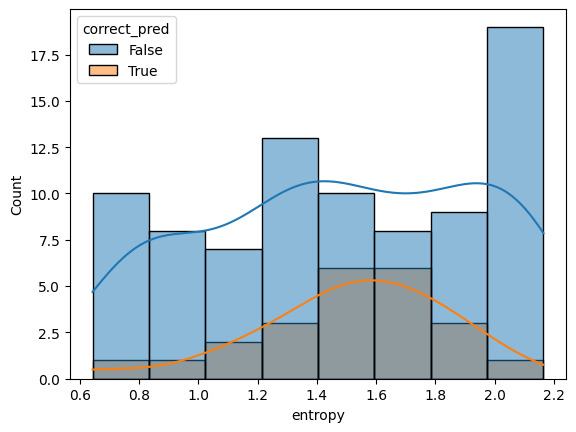

In [175]:
sns.histplot(res_df, x="entropy", hue="correct_pred", kde=True)

In [158]:
res_df.loc[res_df["true_cls"] >= 12].max()

preds              16
true_cls           16
true_reg       -0.902
entropy         2.164
correct_pred     True
dtype: object

In [165]:
res_df.loc[res_df["true_cls"] <= 6].min()

preds                  7
true_cls               6
true_reg           1.334
entropy         0.815229
correct_pred       False
dtype: object

In [166]:
res_df["preds"].value_counts()

preds
11    24
8     23
12    20
13    14
9     10
7      7
10     6
16     2
14     1
Name: count, dtype: int64

Text(0.5, 1.0, 'AF-W8FZ69')

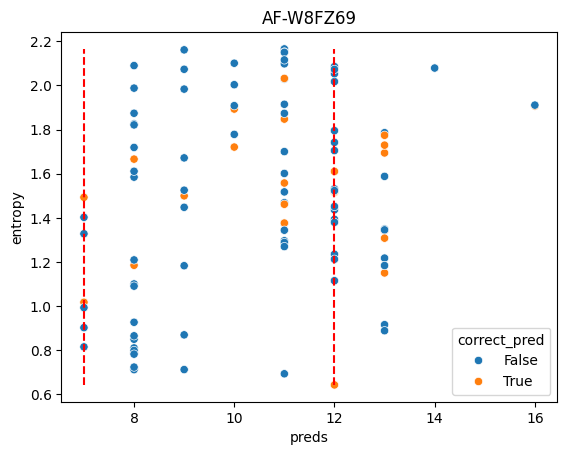

In [163]:
sns.scatterplot(data=res_df, x="preds", y="entropy", hue="correct_pred")
plt.vlines(x=12, ymin=min(entrs[0]), ymax=max(entrs[0]), color='r', linestyle='--')
plt.vlines(x=7, ymin=min(entrs[0]), ymax=max(entrs[0]), color='r', linestyle='--')
plt.title("AF-W8FZ69")

In [136]:
spearmanr(res_df["preds"], res_df["true"]), spearmanr(res_df["entropy"], res_df["true"]), spearmanr(res_df["preds"], res_df["entropy"])

(SignificanceResult(statistic=np.float64(0.7516274097629582), pvalue=np.float64(1.0836019815289053e-20)),
 SignificanceResult(statistic=np.float64(0.2767358347006098), pvalue=np.float64(0.0039075189624613324)),
 SignificanceResult(statistic=np.float64(0.22037564826060724), pvalue=np.float64(0.02255276670565572)))

Text(0, 0.5, 'Entropy')

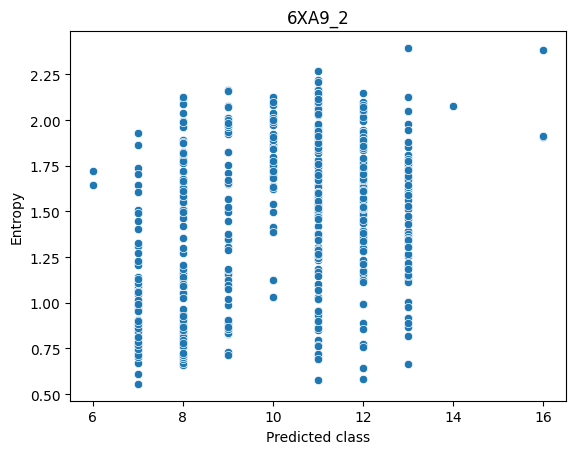

In [102]:
sns.scatterplot(x=preds[0], y=entrs[0])
plt.title("6XA9_2")
plt.xlabel("Predicted class")
plt.ylabel("Entropy")

Text(0, 0.5, 'Entropy')

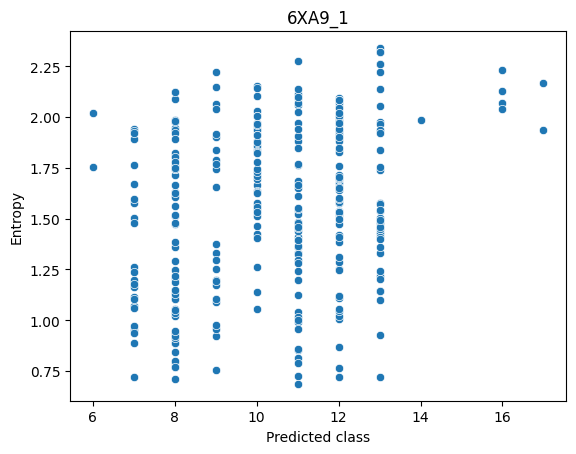

In [76]:
sns.scatterplot(x=preds[1], y=entrs[1])
plt.title("6XA9_1")
plt.xlabel("Predicted class")
plt.ylabel("Entropy")

Text(0, 0.5, 'Entropy')

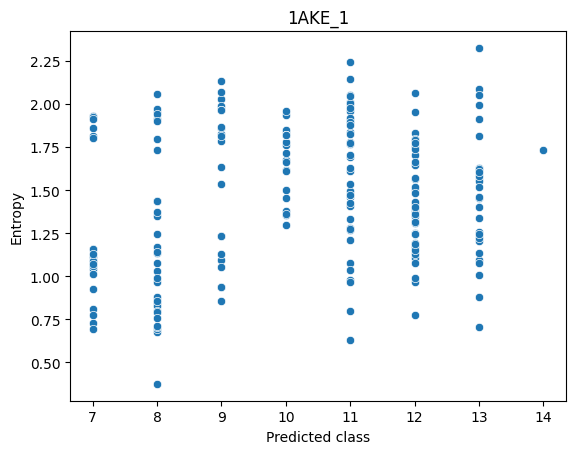

In [77]:
sns.scatterplot(x=preds[2], y=entrs[2])
plt.title("1AKE_1")
plt.xlabel("Predicted class")
plt.ylabel("Entropy")

In [72]:
from scipy.stats import pearsonr, spearmanr

pearsonr(preds[0], entrs[0]), spearmanr(preds[0], entrs[0])

(PearsonRResult(statistic=np.float64(0.3214798784330963), pvalue=np.float64(0.0036402871711195225)),
 SignificanceResult(statistic=np.float64(0.24972945585089082), pvalue=np.float64(0.02548188975257413)))

In [73]:
print(pearsonr(preds[0], entrs[0]), spearmanr(preds[0], entrs[0]))
print(pearsonr(preds[1], entrs[1]), spearmanr(preds[1], entrs[1]))
print(pearsonr(preds[2], entrs[2]), spearmanr(preds[2], entrs[2]))

PearsonRResult(statistic=np.float64(0.3214798784330963), pvalue=np.float64(0.0036402871711195225)) SignificanceResult(statistic=np.float64(0.24972945585089082), pvalue=np.float64(0.02548188975257413))
PearsonRResult(statistic=np.float64(0.2674475359142888), pvalue=np.float64(1.305449081896511e-06)) SignificanceResult(statistic=np.float64(0.2374086694808679), pvalue=np.float64(1.8836565539597595e-05))
PearsonRResult(statistic=np.float64(0.2559678349867429), pvalue=np.float64(0.00015320242627171626)) SignificanceResult(statistic=np.float64(0.2127962106182049), pvalue=np.float64(0.0017442431913793572))


In [41]:
model.preds_list[0, 0, :-1]

array([-13.082121  ,  -4.6526713 ,  -3.9662833 ,  -3.6755037 ,
        -3.2427483 ,  -2.2848747 ,  -1.0160701 ,   0.2123723 ,
         0.95038164,   1.3218168 ,   1.5347053 ,   1.5250981 ,
         1.3259283 ,   0.898893  ,  -0.1474976 ,  -1.0954769 ,
        -1.4632484 ,  -1.4664717 ,  -1.9267285 ,  -2.1163974 ,
        -2.7429411 ], dtype=float32)

In [14]:
cls_preds = np.argmax(model.preds_list[:, :, :-1], axis=-1)
reg_preds = model.preds_list[:, :, -1]
cls_preds.shape, reg_preds.shape

((3, 318), (3, 318))

In [19]:
cls_preds[2]

array([ 9, 12,  7,  7,  8,  8, 11, 10, 13, 11, 10, 11, 13, 11, 11, 12,  9,
       12,  9,  7,  9, 13, 11, 11, 11,  7, 13, 13,  7, 11, 11, 12, 11,  9,
        7, 11, 10,  9,  8, 13, 12, 12, 11,  8,  8, 12,  8, 12,  9, 13, 11,
        7, 10,  7, 10, 12, 13,  9,  7, 11, 13, 13,  8,  8,  7, 10,  8,  8,
       13, 13, 12,  7, 13, 12,  8, 12,  7,  7, 12, 11,  8,  8,  8, 13, 11,
        8, 12, 12, 11,  7, 14, 12,  9, 13, 10,  9, 12, 13,  9, 12,  7, 11,
        8, 12,  9,  8,  8, 13,  8, 13,  8, 12, 13, 13,  8,  7,  8, 13, 12,
        8,  8, 12, 12, 12,  8, 10, 10, 11, 11, 12, 11,  8, 13, 11,  7,  9,
        9, 11, 11, 13,  7, 10,  8, 12, 10, 12,  9,  8, 10, 12, 13, 11,  8,
       11, 10,  7,  8, 10, 12, 12, 12,  9, 10,  8, 10, 11, 11,  8,  9, 11,
        9, 11, 12,  8, 11, 10, 12,  8,  7, 11, 13, 10, 12, 12, 13, 10,  7,
       11, 12, 11, 11, 13, 11,  9, 12,  8, 11, 12, 11, 10, 13,  8, 10,  9,
        8,  9, 11, 12,  8, 12,  9,  7,  8, 11,  9, 10,  8, 10, 10,  9, 10,
       10, 10, 10, 10, 10

In [28]:
seq_lens = predict_df["full_seq"].str.len().to_numpy()

In [34]:
reg_preds_trimmed = [reg_preds[i, :seq_lens[i]] for i in range(len(seq_lens))]
reg_preds_trimmed[0].shape

(140,)

In [50]:
cls_preds_trimmed = [cls_preds[i, :seq_lens[i]] for i in range(len(seq_lens))]
cls_preds_trimmed[0].shape

(140,)

In [61]:
inv_translate_dict[cls_preds_trimmed[0][0]]

'f9'

In [40]:
len(cls_preds_trimmed), len(fasta_dict)

(89, 89)

In [62]:
with open("../data/frustration/cls_preds.fasta", "w") as f:
    for id, pred in zip(predict_df["proteinID"], cls_preds_trimmed):
        f.write(f">{id}\n")
        f.write(",".join([inv_translate_dict[x] for x in pred]) + "\n")

In [55]:
with open("../data/frustration/reg_preds.fasta", "w") as f:
    for id, pred in zip(predict_df["proteinID"], reg_preds_trimmed):
        f.write(f">{id}\n")
        f.write(",".join([str(x) for x in pred]) + "\n")

In [63]:
",".join([str(x) for x in cls_preds_trimmed[1]])

'11,8,10,12,12,12,14,12,11,7,12,11,11,10,9,13,7,12,12,11,10,11,12,10,12,11,13,9,8,13,12,11,8,12,12,9,12,11,11,13,11,16,9,10,10,9,8,8,9,10,12,12,12,12,8,10,11,11,12,13,12,7,9,9,9,7,11,11,9,8,13,11,8,7,13,8,13,12,10,8,11,11,8,12,11,8,11,12,16,12,8,9,7,12,11,8,13,9,12,8,8,12,11,8,8,8,7,11,8,10,7,11,11,11,11,12,9,11,13,11,8,11,11,12,8,13,13,8,8,11,9,8,12,11,8,8,11,12,12,14,10'

In [8]:
# for all the fasta ids, check if they are in the dataframe
fasta_ids_in_df = fasta_ids.intersection(set(df["proteinID"].unique()))
print(f"Fasta IDs present in dataframe: {len(fasta_ids_in_df)} out of {len(fasta_ids)}")

Fasta IDs present in dataframe: 0 out of 89


In [12]:
# print all the proteinIDs in the dataframe that do not start with AF
pdb_ids = [pid[:-3] for pid in df["proteinID"].unique() if not pid.startswith("AF")]
print(f"Protein IDs not starting with 'AF': {len(pdb_ids)}")
print(pdb_ids[:10])


Protein IDs not starting with 'AF': 885
['2zzg', '3roz', '2we5', '5zcw', '2z53', '2j0f', '1xfc', '3c2v', '4bta', '3ekm']


In [23]:
#check if 2rao is in pdb_ids
print("2dn1" in pdb_ids)

False


In [ ]:
#fetch CATH annotation for 2rao from pdb
url = "http://www.cathdb.info/version/v4_3_0/api/rest/id/2rao"
url = "http://www.cathdb.info/version/v4_3_0/api/rest/id/2dn1A.pdb"
response = requests.get(url)
if response.status_code == 200:
    data = response.json()
    print(data)
    print(data['cath'])
else:
    print(f"Failed to retrieve data for 2raoA: {response.status_code}")

In [21]:
response.text

'ATOM      1  N   VAL A   1       4.612  14.731   4.997  1.00 26.33\nATOM      2  CA  VAL A   1       5.012  16.037   5.603  1.00 25.67\nATOM      3  C   VAL A   1       5.841  16.793   4.582  1.00 24.45\nATOM      4  O   VAL A   1       6.896  16.344   4.102  1.00 24.62\nATOM      5  CB  VAL A   1       5.801  15.879   6.942  1.00 25.78\nATOM      6  CG1 VAL A   1       5.970  17.227   7.653  1.00 25.86\nATOM      7  CG2 VAL A   1       5.141  14.831   7.865  1.00 26.18\nATOM      8  N   LEU A   2       5.358  17.974   4.266  1.00 23.33\nATOM      9  CA  LEU A   2       5.948  18.801   3.233  1.00 21.46\nATOM     10  C   LEU A   2       7.132  19.618   3.764  1.00 21.59\nATOM     11  O   LEU A   2       6.997  20.277   4.785  1.00 20.43\nATOM     12  CB  LEU A   2       4.831  19.693   2.665  1.00 21.14\nATOM     13  CG  LEU A   2       3.634  18.954   2.032  1.00 19.54\nATOM     14  CD1 LEU A   2       2.472  19.907   1.583  1.00 18.65\nATOM     15  CD2 LEU A   2       4.139  18.173 

In [27]:

url = f"https://www.cathdb.info/api/domain_summary/2raoA.pdb"
response = requests.get(url)
if response.status_code == 200:
    data = response.json()
    print([d['cath_id'] for d in data.get('domains', [])])
else:
    print([])


[]
